<a href="https://colab.research.google.com/github/sbhanpuri/NASAHackathonIMADE/blob/main/PhaseNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Jupyter notebook to work with the data

# Read in and plot the Apollo 12 Grade A catalog

In [1]:
!pip install Obspy

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

Let's take a look at the training data for the lunar dataset. In addition to the data itself, we include a catalog that will tell you which events happen when in the data. The catalog includes the name of the file, the absolute time, the relative time in seconds (relative to the start of the file), the event ID (evid), and the type of moonquake. The types of moonquakes include impacts, deep moonquakes, and shallow moonquakes. You do not have to worry about predicting the type of moonquakes, that's just fun information for you to know!

**Note**: For your prediction, feel free to include either the absolute time or relative time, just make sure to mark it using the same header in the CSV file so we can easily score it!

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
cat_directory = '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


## Select a detection

Let's pick the first seismic event in the catalog and let's take a look at the absolute time data. The way we show it here is by using pandas `.iloc` and datetime `.strptime`. We are going to keep the format shown in the absolute time header, which is `'%Y-%m-%dT%H:%M:%S.%f'`

In [5]:
row = cat.iloc[6]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1970, 6, 26, 20, 1)

In [6]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

72060.0

In [7]:
# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1970-06-26HR00_evid00009'

## Read the CSV file corresponding to that detection

We will now find the csv data file corresponding to that time and plot it!

In [8]:
data_directory = '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA'
test_filename = 'xa.s12.00.mhz.1970-06-26HR00_evid00009.csv'
csv_file = f'{data_directory}/{test_filename}'
data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-06-26T00:00:00.116000,0.000000,-6.727977e-16
1,1970-06-26T00:00:00.266943,0.150943,-8.646711e-16
2,1970-06-26T00:00:00.417887,0.301887,-9.298738e-16
3,1970-06-26T00:00:00.568830,0.452830,-8.589095e-16
4,1970-06-26T00:00:00.719774,0.603774,-7.139047e-16
...,...,...,...
572418,1970-06-27T00:00:02.832981,86402.716981,5.039820e-17
572419,1970-06-27T00:00:02.983925,86402.867925,-9.191068e-18
572420,1970-06-27T00:00:03.134868,86403.018868,-2.796955e-17
572421,1970-06-27T00:00:03.285811,86403.169811,-9.037156e-17


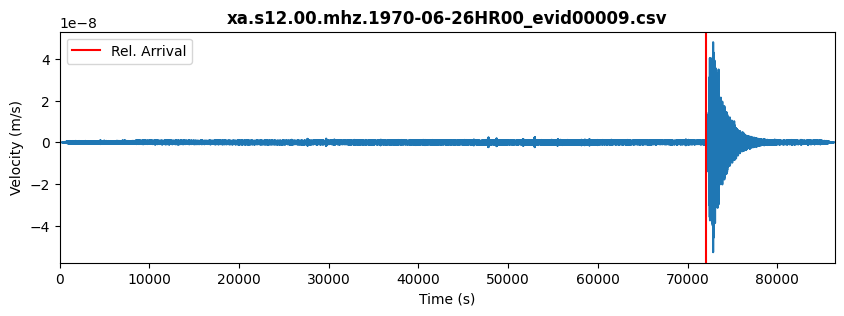

In [9]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

What if you wanted to plot in absolute time instead? The operations are very similar, just with a little extra datetime. It takes a bit longer, so we recommend working in relative time to start with!

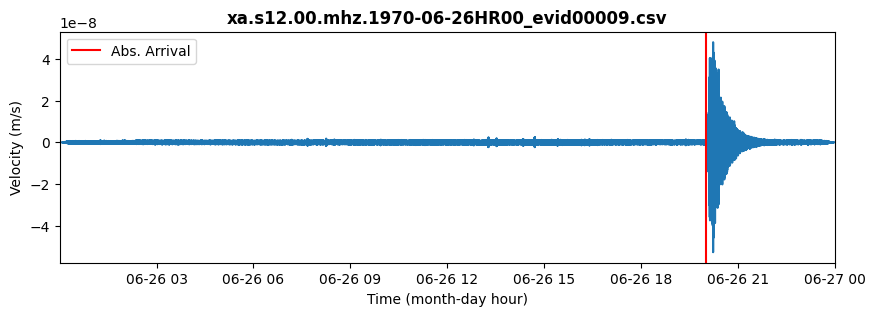

In [10]:
# Read in time steps and velocities
csv_times_dt = []
for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

### Alternatively: read the miniseed file corresponding to that detection

Same procedure as above, just using the miniseed file.

In [11]:
data_directory = '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA'
test_filename = 'xa.s12.00.mhz.1970-06-26HR00_evid00009.mseed'
mseed_file = f'{data_directory}/{test_filename}'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-06-26T00:00:00.116000Z - 1970-06-27T00:00:03.436755Z | 6.6 Hz, 572423 samples

In [12]:
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-06-26T00:00:00.116000Z
         endtime: 1970-06-27T00:00:03.436755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [13]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

72059.884

### Plot the trace and mark the arrival!

Use a similar method to plot the miniseed data and seismic arrival.

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-06-26HR00_evid00009.mseed')

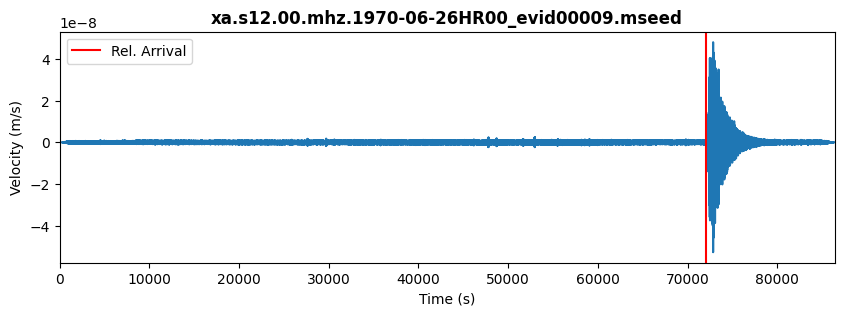

In [14]:
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

There are multiple ways that we can do the absolute time using datetime, here is a simple way using the `.timedelta` method

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-06-26HR00_evid00009.mseed')

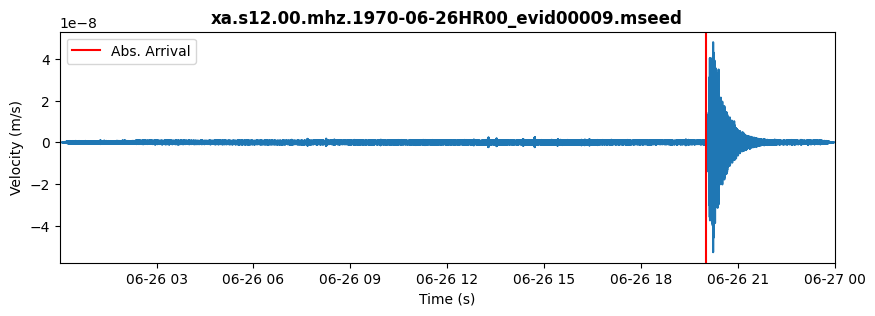

In [15]:
# Create a vector for the absolute time
tr_times_dt = []
for tr_val in tr_times:
    tr_times_dt.append(starttime + timedelta(seconds=tr_val))

# Plot the absolute result
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times_dt,tr_data)

# Mark detection
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

# Make the plot pretty
ax.set_xlim([min(tr_times_dt),max(tr_times_dt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')


It's completely up to you whether to work with the CSV file or the miniseed files. We recommend working with the miniseed file as it's a bit faster to run.

## Let's filter the trace

Sometimes, it's useful to filter the trace to bring out particular frequencies. This will change the shape of the data and make it easier to see certain parts of the signal. In this example, we will filter the data using a bandpass filter between 0.01 Hz to 0.5 Hz.

In [16]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [17]:
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

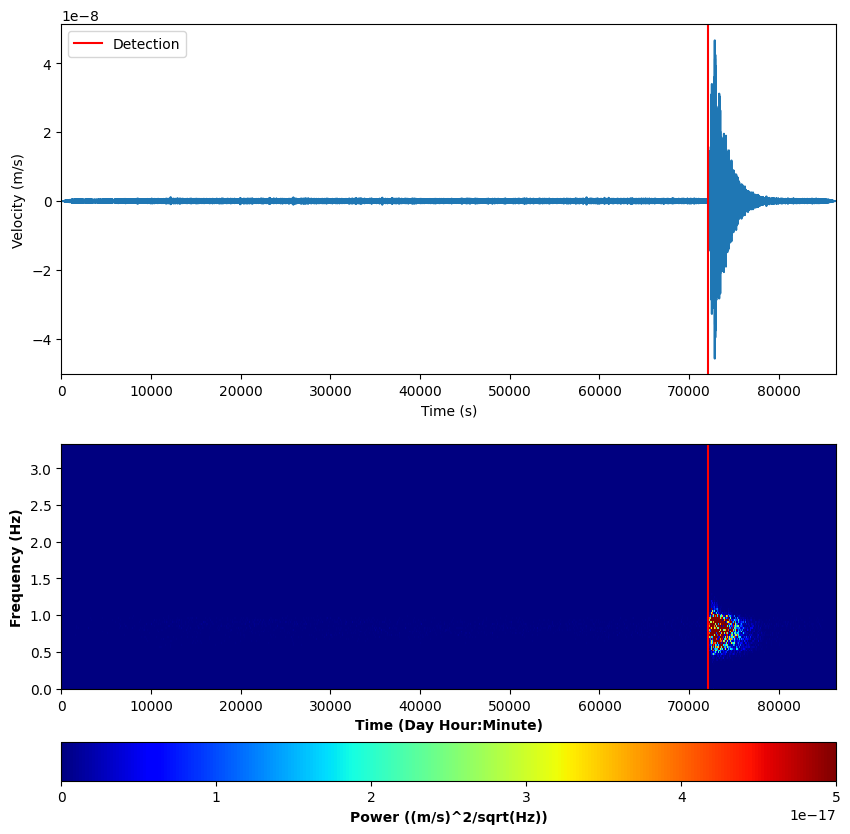

In [18]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

# Sample short-term average / long-term average (STA/LTA) detection algorithm

A STA/LTA algorithm moves two time windows of two lengths (one short, one long) across the seismic data. The algorithm calculates the average amplitude in both windows, and calculates the ratio between them. If the data contains an earthquake, then the short-term window containing the earthquake will be much larger than the long-term window -- resulting in a detection.

Text(0, 0.5, 'Characteristic function')

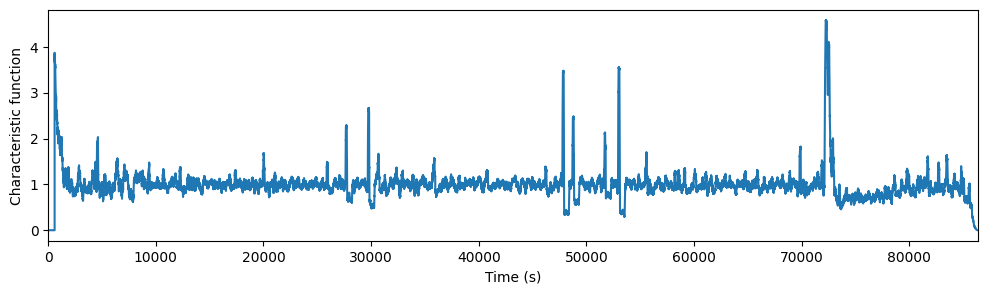

In [19]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 120
lta_len = 600

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

Next, we define the values of the characteristic function (i.e. amplitude ratio between short-term and long-term windows) where we flag a seismic detection. These values are called triggers. There are two types of triggers -- "on" and "off", defined as follows:

1. "on" : If the characteristic function is above this value, then a seismic event begins.
2. "off" : If the characteristic function falls below this value (after an "on" trigger), than a seismic event ends.

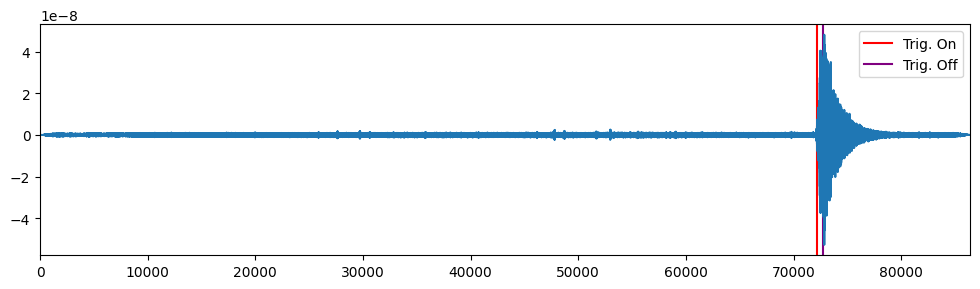

In [20]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on".
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()

**Note**: You do not have to worry about marking the end of the seismic trace (as you can see, even for us it's not very accurate!). For this challenge, all we care about is the start of the seismic waveform.

## Sample detection export into a catalog!
There are many ways to do this, but we'll show a way to do it using pandas.

In [21]:
# File name and start time of trace
fname = row.filename
starttime = tr.stats.starttime.datetime

# Iterate through detection times and compile them
detection_times = []
fnames = []
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds = tr_times[triggers[0]])
    on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
    detection_times.append(on_time_str)
    fnames.append(fname)

# Compile dataframe of detections
detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':tr_times[triggers[0]]})
detect_df.head()

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec)
0,xa.s12.00.mhz.1970-06-26HR00_evid00009,1970-06-26T20:03:21.323547,72201.207547


This can then be exported to a csv using:

`detect_df.to_csv('output/path/catalog.csv', index=False)`

# Download additional data from Earth-based stations

You may find that you need to download additional data from Earth stations to supplement your models and algorithms. We recommend that you download any events from IRIS (Incorporated Research Institutations for Seismology).

https://www.iris.edu/hq/

**Note**: The organization has been recently renamed to SAGE (Seismological Facility for the Advancement of Geoscience), but all the previous links should still work.

They maintain and curate data from seismic stations all around the world. There are many different ways to get data from them, but I recommend using the utility *PyWeed*:

https://ds.iris.edu/ds/nodes/dmc/software/downloads/pyweed/

We can use the utility to select seismic stations and the earthquake data (or **events**) recorded at those stations.

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/eq_detector_images/station_data_location.png" alt="Drawing" style="width: 1200px;">

For this test case, let's download all of the earthquakes magnitude 3 and above that are within 1 degree distance (approximately 110 km) from a site called PFO (Pinon Flat Observatory) in California. **Location** is a number designating the instrument at a particular site (sites may have multiple instruments), and **channel** is an IRIS code that specifies instrument information.

In short, the first latter refers to the samplerate of the instrument (how many data points it records per second), the second to the type of instrument (certain types of seismometers are better at recording nearby earthquakes while others are more suited for distant earthquakes), and the last to the directional component being recored (most seismometers will record motion across two horizontal directions and the vertical). We will pick the channel HHZ, which refers to a (H) high-samplerate (100 samples per second) (H) strong-motion accelerometer (best resolution for nearby strong earthquakes) recording in the (Z) vertical direction. Once you've selected all the earthquakes, you can download the traces.

An earthquake is composed of the following types of waves (in order): pressure (P-wave), shear (S-wave), and surface (Rayleigh and Love). For our challenge, we are only interested in identifying the start of the earthquake. The IRIS dataset contains P-wave arrivals (onset of the P-wave at the seismometer) for each earthquake. In order to get noise prior to the earthquake arrival, we pick our data traces to span 101 seconds before to 60 seconds past the P-wave arrival:


<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/eq_detector_images/selected_seismograms.png" alt="Drawing" style="width: 1200px;">


As you can see from the output list, some of the earthquakes don't record any earthquake data (3.4 Ml 2005-08-31) and others have an incorrect P-wave arrival time (4.0 Ml 2005-08-31). Make sure to go through the earthquakes and remove those types of events from the waveform preview prior to download. For output file type, choose miniseed to match the planetary data (SAC is probably fine too, but the file sizes tend to be a bit bigger).

## Thank you very much for being a part of this challenge! Good luck!!!

In [22]:
!git clone https://github.com/wayneweiqiang/phasenet.git

Cloning into 'phasenet'...
remote: Enumerating objects: 1849, done.
remote: Counting objects: 100% (377/377), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 1849 (delta 240), reused 321 (delta 193), pack-reused 1472 (from 1)
Receiving objects: 100% (1849/1849), 45.94 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (1117/1117), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninsta

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.models import resnet18

class SeismicDataset(Dataset):
  def __init__(self, data_path):
    self.data = pd.read_csv(data_path)

        # Convert 'Time' column to datetime and then to float
    if 'Time' in self.data.columns:
      self.data['Time'] = pd.to_datetime(self.data['Time'])
      self.data['Time'] = (self.data['Time'] - self.data['Time'].min()).dt.total_seconds()

        # Select only numeric columns
      # Select only numeric columns
    self.data = self.data.select_dtypes(include=[np.number])

    # Convert all data to float32
    self.data = self.data.astype(np.float32)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return torch.from_numpy(self.data.iloc[idx].values.astype(np.float32)).float()


class PhaseNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(PhaseNet, self).__init__()
        # LSTM layer for time series processing
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # LSTM expects input: (batch_size, sequence_length, input_size)
        lstm_out, (hn, cn) = self.lstm(x)
        # Get the output from the last LSTM cell
        last_hidden_state = lstm_out[:, -1, :]

        # Fully connected layer for classification
        out = self.fc(last_hidden_state)
        return out


class ResNet1D(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super(ResNet1D, self).__init__()
        # Load pre-trained ResNet18 and modify for 1D input
        self.resnet = resnet18(pretrained=True)

        # Replace the first conv2d layer with a conv1d layer
        self.resnet.conv1 = nn.Conv1d(
            in_channels=input_channels,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )

        # Replace the 2D BatchNorm with 1D BatchNorm
        self.resnet.bn1 = nn.BatchNorm1d(64)

        # Replace the maxpool layer with a 1D maxpool
        self.resnet.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Modify the fully connected layer to output num_classes
        self.resnet.fc = nn.Linear(512, num_classes)  # Adjusted input size for fully connected layer

        # Remove avgpool or adjust it to 1D if needed (for example, AdaptiveAvgPool1d)
        self.resnet.avgpool = nn.AdaptiveAvgPool1d(1)

        # Convert all Conv2d and BatchNorm2d into Conv1d and BatchNorm1d
        for name, module in list(self.resnet.named_modules()):
            if isinstance(module, nn.Conv2d):
                in_channels = module.in_channels
                out_channels = module.out_channels
                kernel_size = module.kernel_size[0]
                stride = module.stride[0]
                padding = module.padding[0]
                new_module = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

                parent_name, child_name = name.rsplit('.', 1)
                parent_module = self.resnet
                for part in parent_name.split('.'):
                    parent_module = getattr(parent_module, part)
                setattr(parent_module, child_name, new_module)

            elif isinstance(module, nn.BatchNorm2d):
                num_features = module.num_features
                new_module = nn.BatchNorm1d(num_features)

                parent_name, child_name = name.rsplit('.', 1)
                parent_module = self.resnet
                for part in parent_name.split('.'):
                    parent_module = getattr(parent_module, part)
                setattr(parent_module, child_name, new_module)

    def forward(self, x):
        # Forward pass through the modified ResNet layers
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)

        # Flatten the tensor and pass through the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.resnet.fc(x)
        return x


# Training function to include accuracy tracking
def train_model(phasenet_model, resnet1d_model, dataloader, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()  # Loss function for classification
    optimizer_resnet = torch.optim.Adam(resnet1d_model.parameters(), lr=learning_rate)
    optimizer_phasenet = torch.optim.Adam(phasenet_model.parameters(), lr=learning_rate)

    train_losses = []
    phasenet_accuracies = []
    resnet_accuracies = []

    for epoch in range(num_epochs):
        epoch_loss_resnet = 0
        epoch_loss_phasenet = 0
        correct_phasenet = 0
        correct_resnet = 0
        total_samples = 0

        for batch in dataloader:
            # Reshape the input for ResNet1D: [batch_size, 1, sequence_length]
            ResNet1D_input = batch.unsqueeze(1)
            # Reshape the input for PhaseNet: [batch_size, sequence_length, 1]
            phasenet_input = batch.unsqueeze(2)

            # Labels (Random labels for now; in real data, replace with actual labels)
            labels = torch.randint(0, 2, (batch.shape[0],))

            # Forward pass for ResNet1D
            resnet_output = resnet1d_model(ResNet1D_input)
            loss_resnet = criterion(resnet_output, labels)

            # Forward pass for PhaseNet
            phasenet_output = phasenet_model(phasenet_input)
            loss_phasenet = criterion(phasenet_output, labels)

            # Backward pass and optimization
            optimizer_resnet.zero_grad()
            loss_resnet.backward()
            optimizer_resnet.step()

            optimizer_phasenet.zero_grad()
            loss_phasenet.backward()
            optimizer_phasenet.step()

            # Accumulate loss
            epoch_loss_resnet += loss_resnet.item()
            epoch_loss_phasenet += loss_phasenet.item()

            # Accuracy calculation
            _, predicted_phasenet = torch.max(phasenet_output, 1)
            _, predicted_resnet = torch.max(resnet_output, 1)

            correct_phasenet += (predicted_phasenet == labels).sum().item()
            correct_resnet += (predicted_resnet == labels).sum().item()

            total_samples += labels.size(0)

        # Epoch-wise accuracy
        accuracy_phasenet = 100 * correct_phasenet / total_samples
        accuracy_resnet = 100 * correct_resnet / total_samples
        phasenet_accuracies.append(accuracy_phasenet)
        resnet_accuracies.append(accuracy_resnet)

        train_losses.append((epoch_loss_resnet / len(dataloader), epoch_loss_phasenet / len(dataloader)))

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Loss ResNet: {epoch_loss_resnet:.4f}, Loss PhaseNet: {epoch_loss_phasenet:.4f}, '
              f'Accuracy ResNet: {accuracy_resnet:.2f}%, Accuracy PhaseNet: {accuracy_phasenet:.2f}%')

    return train_losses, phasenet_accuracies, resnet_accuracies

# Function to plot results
def plot_results(losses, accuracies_phasenet, accuracies_resnet):
    resnet_losses, phasenet_losses = zip(*losses)

    plt.figure(figsize=(14, 7))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(resnet_losses, label='ResNet Loss')
    plt.plot(phasenet_losses, label='PhaseNet Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(accuracies_phasenet, label='PhaseNet Accuracy')
    plt.plot(accuracies_resnet, label='ResNet Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy')
    plt.legend()

    plt.show()

# Main function
def main():
    batch_size = 64
    num_epochs = 50
    learning_rate = 0.001

    # Load seismic data
    dataset = SeismicDataset('/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-06-26HR00_evid00009.csv')
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize models
    phasenet_model = PhaseNet(input_size=1, hidden_size=64, num_classes=2)
    resnet1d_model = ResNet1D(num_classes=2, input_channels=1)

    # Train models
    losses, accuracies_phasenet, accuracies_resnet = train_model(phasenet_model, resnet1d_model, dataloader, num_epochs, learning_rate)

    # Plot training results
    plot_results(losses, accuracies_phasenet, accuracies_resnet)

if __name__ == '__main__':
    main()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.1MB/s]
